In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.ticker as ticker
from scipy.integrate import simps
from scipy.optimize import curve_fit


from sklearn.linear_model import LinearRegression

In [2]:
BASE_PATH = '../tp5/out/flux/'

In [3]:
def get_linear_regresssion(df):
    x = np.array(df.index)
    y = np.array(df['sum'])
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m , c

In [4]:
def get_simulation_data(df):
    time_flux = df.groupby('time').agg({'ball_id':'count'}); 
    return {
        'discharge' : pd.DataFrame({'time': time_flux.index,'sum': time_flux.cumsum()['ball_id']})
    }

In [5]:
def plot_flux(figure, tiempo, discharge, line, shared_ax, label):
    if shared_ax is None:
        plt.plot(tiempo, discharge,marker='x', label='Descarga')
        plt.plot(tiempo, line, label='Regresión lineal')
        plt.xlabel('Tiempo')
        plt.ylabel('Cantidad de pelotas')
        plt.legend()
        plt.savefig(figure)
        plt.clf()
    else:
        # color = next(shared_ax._get_lines.prop_cycler)['color']
        shared_ax.plot(tiempo, discharge, label=label, marker='x')
        shared_ax.plot(tiempo, line)

In [6]:
def plot_map(name,plot_map, xlabel, ylabel, log_scale):
    x = [position for position in plot_map.keys()]
    y = [value[0] for value in plot_map.values()]
    errors = [value[1] for value in plot_map.values()]
        
    plt.errorbar(x, y, yerr=errors, fmt='o', color='black', ecolor='red', capsize=3)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if log_scale:
        plt.yscale("log")
    plt.xticks(x)
    plt.grid(True)
    plt.savefig(name)
    plt.clf()

In [7]:
def get_charge(path):
    df = pd.read_csv(path)
    df = get_simulation_data(df)
    df = df['discharge']
    m, c = get_linear_regresssion(df)
    y = m * (df.index) + c
    S = np.sqrt(sum((df['sum'] - y) ** 2) / (len(df.time) - 2))
    time_mean = np.mean(df.index)
    SS = np.sqrt(sum((df.index - time_mean) ** 2))
    return m, (S/SS)
    

In [8]:
    # function for generating the discharge curve for the freq, 
    # receiving the csv path as parameter
    def plot_discharge_line_for_freq(freq, path, shared_ax):        
        df = pd.read_csv(path)
        df = get_simulation_data(df)
        df = df['discharge']
        m, c = get_linear_regresssion(df)
        y = m * (df.index) + c
        plot_flux(f'{freq}Discharge.png',df.index, df['sum'], y, shared_ax, str(freq) + ' Hz')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


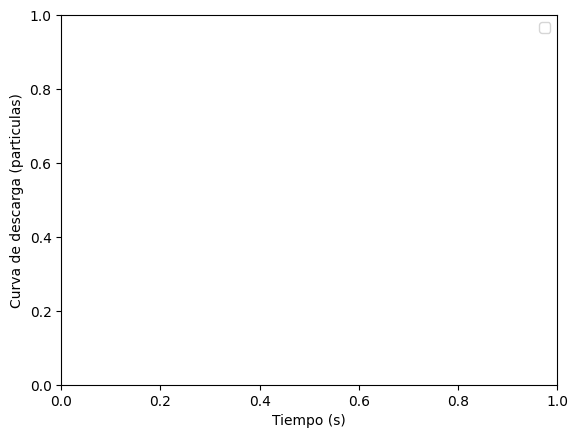

<Figure size 640x480 with 0 Axes>

In [9]:
# Ejercicio 1. 
def plot_caudal_by_frequency():
    path = f"{BASE_PATH}/"
    frequencies = [5,10, 15,20, 30,50]
    sub_freq = [15, 50]
    result = {}
    fig, shared_ax = plt.subplots()

    for freq in frequencies: 
        regex = '*fq'+ str(freq)+'_gap0.03_i*.csv'
        files = Path(path).glob(regex)
        for f in files: 
            dfs = get_charge(f)
            if freq in sub_freq:
                plot_discharge_line_for_freq(freq, f, shared_ax)
            result[freq] = dfs
        
    shared_ax.set_xlabel('Tiempo (s)')
    shared_ax.set_ylabel('Curva de descarga (particulas)')
    shared_ax.legend()
    plt.show()
    plt.clf()
    plot_map("fluxVsFreq.png", result, "Frecuencia (Hz)", "Caudal (Particulas / s)", False)

plot_caudal_by_frequency()

In [10]:
    # function for generating the discharge curve for the gap, 
    # receiving the csv path as parameter
    def plot_discharge_line_for_gap(gap, path, ax):        
        df = pd.read_csv(path)
        df = get_simulation_data(df)
        df = df['discharge']
        m, c = get_linear_regresssion(df)
        y = m * (df.index) + c
        plot_flux(f"{gap}_Discharge.png", df.index, df['sum'], y, ax, str(gap) + ' m')

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

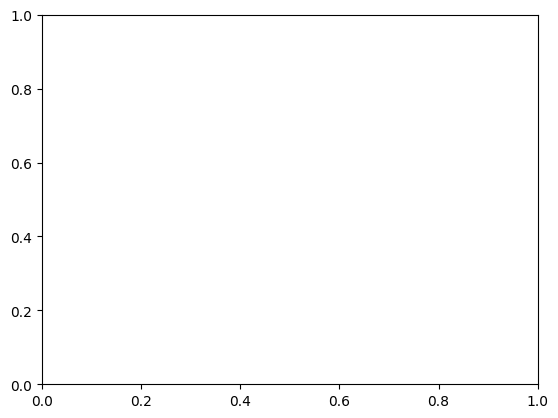

In [11]:
# Ej 2. 
def plot_discharge_line(freq):
    base = f"{BASE_PATH}/"
    gaps = [0.04, 0.05, 0.06]
    
    plt.clf()
    fig, shared_ax = plt.subplots()
    for gap in gaps: 
        regex = f"*fq{freq}_gap"+ str(gap)+'*_i*.csv'
        files = Path(base).glob(regex)
        path = [f for f in files][0]
        plot_discharge_line_for_gap(gap, path, shared_ax)
        
    shared_ax.set_xlabel('Tiempo (s)')
    shared_ax.set_ylabel('Curva de descarga (particulas)')
    shared_ax.legend()
    
    plt.show()

OPTIMAL_FREQ = 50
plot_discharge_line(OPTIMAL_FREQ)

In [ ]:
# generate all the discharge curves  
def plot_discharge_line():
    base = f"{BASE_PATH}/"
    frequencies = [5,10, 15, 20, 30, 50]
    for freq in frequencies: 
        regex = '*fq'+ str(freq)+'*_i*.csv'
        files = Path(base).glob(regex)
        path = [f for f in files][0]
        plot_discharge_line_for_freq(freq, path, None)

plot_discharge_line()

In [ ]:
def get_caudal_by_gap(freq):
    path = f"{BASE_PATH}/"
    gaps = [0.04, 0.05, 0.06]
    caudales = []
    result = {}
    result_map = {}
    for gap in gaps: 
        regex = f"*fq{freq}_gap{gap}*_i*.csv"

        files = Path(path).glob(regex)
        caudal = [get_charge(f) for f in files][0]
        result_map[gap] = caudal
        caudales.append(caudal[0])
        
    result["d"] = gaps
    result["q"] = caudales
    
        
    plot_map("fluxVsAncho.png", result_map, "Ancho(m)", "Caudal (particulas / s)", False)

    return result

In [ ]:
get_caudal_by_gap(50)

In [ ]:
def linear_func(d, c):
    return d - (0.01) * c

def plot_beverloo(points,c):
    B = (200 /(0.35 * 0.2)) * np.sqrt(0.05)
    r = 0.01
    x = np.arange(np.abs(c*r), 0.07, 0.001)
    y = B * ((x-c*r)**1.5)
    x_p = [p[0] for p in points]
    y_p = [p[1] for p in points]
    
    plt.plot(x,y, label='Ley de Beverloo')
    plt.plot(x_p, y_p, marker='x', linestyle='None',label='Resultados')
    plt.xlabel('Ancho(m)')
    plt.ylabel('Caudal ')
    # plot(points)
    plt.legend()
    plt.savefig("Beverloo.png")

In [ ]:
dictio = get_caudal_by_gap(50)
D = dictio["d"]
Q = dictio["q"]
D = np.array(D) #pasando a centimetros
B = (200 /(0.35 * 0.2)) * np.sqrt(0.05)
Q_despejado = np.exp((np.log(Q/B))/(1.5))

popt, _ = curve_fit(linear_func, D, Q_despejado)
b_opt = popt[0] # c que aproxima. 
print(b_opt)
c_despejado = (D - Q_despejado)/(0.01) 
print(c_despejado)

points = []
for d,q in zip(D,Q):
    points.append((d,q))

plot_beverloo(points, b_opt)

In [ ]:
# time_delta = 1
# time_bins = np.arange(0, 10, time_delta)

# data = []
# df_without_index = df.reset_index()
# for i in range(0, len(time_bins) - 1):
#     lower = time_bins[i]
#     upper = time_bins[i + 1]

#     particles = df_without_index[(df_without_index['time'] < upper) & (df_without_index['time'] >= lower)]['ball_id'].sum()
#     data.append({'time': lower, 'particles': particles})

# q_df = pd.DataFrame(data)
# q_df.plot(x='time', y='particles')

# q_df.mean()

In [ ]:
# rolling_df = df.copy().reset_index()
# rolling_df['Timestamp'] = pd.to_datetime(rolling_df['time'], unit='s')
# rolling_df.set_index('Timestamp', inplace=True)
# rolling_df.rolling(window='1000ms')['ball_id'].sum().plot()

## Comparación sin oscilación

1. Identificar valor de C para Beverloo con sistema no oscilatorio
2. Calcular el impacto en el "d" efectivo al oscilar el sistema

In [ ]:
VOLUME_HEIGHT = 0.25 # meters
VOLUME_WIDTH = 0.2 # meters
PARTICLES_AMOUNT = 200
PARTICLE_AVG_RADIUS = 0.01 # meters
GRAVITY = 0.05 # m/s²

In [ ]:
def approximate_beverloo_c(
    D: list[float],
    Q: list[float],
    volume_width=VOLUME_WIDTH,
    volume_height=VOLUME_HEIGHT,
    particles_amount=PARTICLES_AMOUNT,
    particle_avg_radius=PARTICLE_AVG_RADIUS,
    gravity=GRAVITY
):
    D = np.array(D)
    total_volume = volume_width * volume_height
    B = (particles_amount /(total_volume)) * np.sqrt(gravity)
    Q_despejado = np.exp(np.log(Q / B) / 1.5)

    popt, _ = curve_fit(linear_func, D, Q_despejado)
    b_opt = popt[0]  # c que aproxima.
    return b_opt

In [ ]:
def beverloo_df(
    x,
    c,
    volume_width=VOLUME_WIDTH,
    volume_height=VOLUME_HEIGHT,
    particles_amount=PARTICLES_AMOUNT,
    particle_avg_radius=PARTICLE_AVG_RADIUS,
    gravity=GRAVITY
):
    total_volume = volume_width * volume_height
    B = particles_amount / total_volume * np.sqrt(gravity)
    
    y = B * ((x - c * particle_avg_radius) ** 1.5)
    
    return pd.DataFrame({'x': x, 'y': y})

In [ ]:
def plot_beverloo_curve(df, ax, label="Ley de Beverloo"):
    # df = df[(df['x'] > 0.037) & (df['x'] < 0.063)].copy()
    
    ax.plot(df['x'], df['y'], label=label)
    
def plot_beverloo_experiment_data_points(df, ax, label="Resultados", marker='o'):
    x_p = [p[0] for p in df]
    y_p = [p[1] for p in df]
    
    ax.plot(x_p, y_p, marker=marker, linestyle='None', label=label, alpha=1)

In [13]:
def get_caudal_df(freq: int):
    path = f"{BASE_PATH}/"
    gaps = [0.04, 0.05, 0.06]
    caudales = []
    errors = []
    result_map = {}
    
    for gap in gaps: 
        regex = f"*fq{freq}_gap{gap}*_i*.csv"
        files = Path(path).glob(regex)
        caudal = [get_charge(f) for f in files][0]
        result_map[gap] = caudal
        caudales.append(caudal[0])
        errors.append(caudal[1])

    return {"d": gaps, "q": caudales, "error":errors}

In [ ]:
optimal_freq_data = get_caudal_df(freq=50)
print(optimal_freq_data)
c = approximate_beverloo_c(optimal_freq_data['d'], optimal_freq_data['q'])
print(f"Fitted c: {c}")

x = np.arange(np.abs(c * PARTICLE_AVG_RADIUS), 0.07, 0.001)

beverloo = beverloo_df(x, c)

fig, ax = plt.subplots()

plot_beverloo_curve(beverloo, ax, "Beverloo freq. óptima")
plot_beverloo_experiment_data_points([x for x in zip(D, Q)], ax, "Resultados freq. óptima", '+')

ax.legend()
ax.set_xlabel('Ancho (m)')
ax.set_ylabel('Caudal (partículas / s)')

# plt.show()

In [ ]:
no_oscilation_data = get_caudal_df(freq=0)
print(no_oscilation_data)
no_oscilation_d = no_oscilation_data['d']
no_oscilation_q = no_oscilation_data['q']
no_oscilation_e = no_oscilation_data['error']
no_oscilation_c = approximate_beverloo_c(no_oscilation_d, no_oscilation_q)

print(f"Fitted c: {no_oscilation_c}")

x = np.arange(np.abs(no_oscilation_c * PARTICLE_AVG_RADIUS), 0.07, 0.001)

beverloo = beverloo_df(x, no_oscilation_c)

plot_beverloo_curve(beverloo, ax, "Beverloo sin osc.")
plot_beverloo_experiment_data_points([x for x in zip(no_oscilation_d, no_oscilation_q)], ax, "Resultados sin osc.", 'x')

ax.legend()

fig

In [ ]:
plt.clf()

In [ ]:
comparison_c_df = pd.DataFrame({'x': optimal_freq_data['d'], 'osc_y': optimal_freq_data['q'], 'no_osc_y': no_oscilation_q})
comparison_c_df['y_ratio'] = (comparison_c_df['osc_y']) / comparison_c_df['no_osc_y']
# comparison_c_df['error'] = (comparison_c_df['y_ratio']) * np.sqrt(((optimal_freq_data['q'] /optimal_freq_data['error'] )**2)
#                                                                   + ((no_oscilation_data['q'] / no_oscilation_data['error'])**2))
print(optimal_freq_data)


comparison_c_df['error'] = comparison_c_df['y_ratio'] * np.sqrt((optimal_freq_data['error'] / comparison_c_df['osc_y'])**2
                                                                 + ( no_oscilation_e / comparison_c_df['no_osc_y'] )**2)

print(comparison_c_df)


result = {x: (y_ratio, error) for x, y_ratio, error in zip(comparison_c_df['x'], comparison_c_df['y_ratio'], comparison_c_df['error'])}
print(result)

plot_map("ganancia.png",result, 'Ancho (m)', '%Ganancia actual', False)

plt.bar(x=comparison_c_df['x'], width=0.005, height=comparison_c_df['y_ratio'])
plt.xlabel('Ancho (m)')
plt.ylabel('% Ganancia caudal')

print(comparison_c_df)

In [ ]:
data = [[0, no_oscilation_c], [10, no_oscilation_c]]
c_df = pd.DataFrame({'x': [0, 10], 'y': [no_oscilation_c, c]})
plt.scatter(x=c_df['x'], y=c_df['y'])
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('c')

## Curva de error

beverloo points for c = 0.0
[ 8.49705831 11.875      15.61009289]
0.0 approximates with error 57.10514950266523
beverloo points for c = 0.05102040816326531
[ 8.33500656 11.69370426 15.41140844]
0.05102040816326531 approximates with error 52.47265929909513
beverloo points for c = 0.10204081632653061
[ 8.17399829 11.51334065 15.21357416]
0.10204081632653061 approximates with error 48.05960731296858
beverloo points for c = 0.15306122448979592
[ 8.01404033 11.33391399 15.01659373]
0.15306122448979592 approximates with error 43.86308086520657
beverloo points for c = 0.20408163265306123
[ 7.85513961 11.15542922 14.82047086]
0.20408163265306123 approximates with error 39.880163835213054
beverloo points for c = 0.25510204081632654
[ 7.69730321 10.97789133 14.62520932]
0.25510204081632654 approximates with error 36.1079365657138
beverloo points for c = 0.30612244897959184
[ 7.54053837 10.8013054  14.43081292]
0.30612244897959184 approximates with error 32.54347576376086
beverloo points for c = 

(1.3265306122448979, 0.34610354739153404)

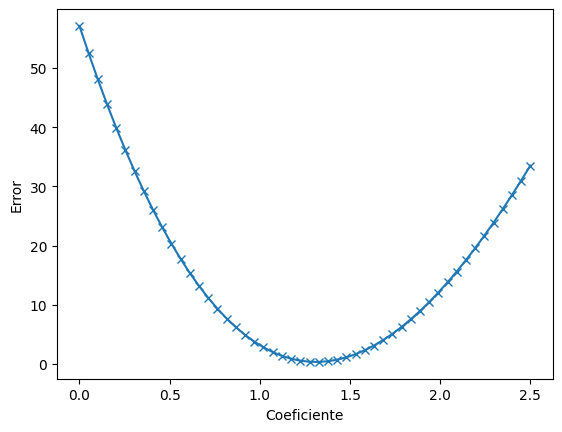

In [9]:
GAPS = np.array([0.04, 0.05, 0.06])
N_PARTICLES = 190
VOL_HEIGHT = 0.2

def beverloo_function(c, gaps=GAPS):
    B = (N_PARTICLES /(VOL_HEIGHT * 0.2)) * np.sqrt(0.05)
    r = 0.01
    y = B * ((gaps-c*r)**1.5)
    print(f"beverloo points for c = {c}")
    print(y)
    return y

def plot_error_curve(c_range, errors):
    fig, ax = plt.subplots()
    ax.plot(c_range, errors, marker='x')
    ax.set_ylabel("Error")
    ax.set_xlabel("Coeficiente")
    fig.savefig("curva_de_error.png")

def calculate_error(y_experiment, y_regression):
    return np.sum((y_experiment - y_regression) ** 2)

def get_error_curve(y_experiment, gaps = GAPS):
    c_range = np.linspace(0., 2.5, 50)
    errors = []
    for c_i in c_range: 
        y_reg = beverloo_function(c_i)
        error = calculate_error(y_experiment, y_reg)
        print(f"{c_i} approximates with error {error}")
        errors.append(error)

    idx_min = np.argmin(errors)
    c_optimo = c_range[idx_min]
    error_minimo = errors[idx_min]

    plot_error_curve(c_range, errors)

    return c_optimo, error_minimo

# df = get_caudal_df(15)
# y_sim = df["q"]
y_sim = [4.5, 8, 10.5]
c_optimo, error_minimo = get_error_curve(y_sim)
c_optimo, error_minimo
